# Stroke Prediction

## Import Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
from sklearn.metrics import precision_score, f1_score, roc_curve, roc_auc_score

## Read Dataset

In [3]:
df = pd.read_csv('stroke_data.csv')

## Dataset Overview

In [4]:
df.shape

(40910, 11)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40910 entries, 0 to 40909
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sex                40907 non-null  float64
 1   age                40910 non-null  float64
 2   hypertension       40910 non-null  int64  
 3   heart_disease      40910 non-null  int64  
 4   ever_married       40910 non-null  int64  
 5   work_type          40910 non-null  int64  
 6   Residence_type     40910 non-null  int64  
 7   avg_glucose_level  40910 non-null  float64
 8   bmi                40910 non-null  float64
 9   smoking_status     40910 non-null  int64  
 10  stroke             40910 non-null  int64  
dtypes: float64(4), int64(7)
memory usage: 3.4 MB


In [6]:
df.describe()

,sex,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
count,40907.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000,40910.000000
mean,0.555162,51.327255,0.213835,0.127719,0.821340,3.461134,0.514886,122.075901,30.406355,0.488609,0.500122
std,0.496954,21.623969,0.410017,0.333781,0.383072,0.780919,0.499784,57.561531,6.835072,0.499876,0.500006
min,0.000000,-9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,55.120000,11.500000,0.000000,0.000000
25%,0.000000,35.000000,0.000000,0.000000,1.000000,3.000000,0.000000,78.750000,25.900000,0.000000,0.000000
50%,1.000000,52.000000,0.000000,0.000000,1.000000,4.000000,1.000000,97.920000,29.400000,0.000000,1.000000
75%,1.000000,68.000000,0.000000,0.000000,1.000000,4.000000,1.000000,167.590000,34.100000,1.000000,1.000000
max,1.000000,103.000000,1.000000,1.000000,1.000000,4.000000,1.000000,271.740000,92.000000,1.000000,1.000000


## Data Preparation

In [7]:
df.rename(columns = {'Residence_type':'residence_type'}, inplace = True)

In [8]:
df.replace({'sex': {0: 'Female', 1: 'Male'},
            'hypertension' : {0: 'No', 1: 'Yes'},
            'heart_disease': {0: 'No', 1: 'Yes'},
            'ever_married': {0:'No', 1: 'Yes'},
            'work_type': {0: 'Never_worked', 1: 'Children',
                          2: 'Govt_job', 3: 'Self-employed', 
                          4: 'Private'},
            'residence_type': {0: 'Rural', 1: 'Urban'},
            'smoking_status': {0: 'Never smoked', 1: 'Smokes'},
            'stroke': {0: 'No', 1: 'Yes'}},
           inplace = True)

In [9]:
df.describe(include='object')

,sex,hypertension,heart_disease,ever_married,work_type,residence_type,smoking_status,stroke
count,40907,40910,40910,40910,40910,40910,40910,40910
unique,2,2,2,2,5,2,2,2
top,Male,No,No,Yes,Private,Urban,Never smoked,Yes
freq,22710,32162,35685,33601,25570,21064,20921,20460


### Outlier Detection

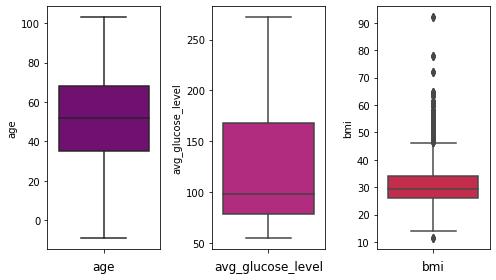

In [10]:
f, ax = plt.subplots(1,3, figsize=(7,4), tight_layout = True)

columns = df.select_dtypes(include='float64').columns
colors = ['purple', 'mediumvioletred', 'crimson', 'salmon', 'peachpuff']
for i, col in enumerate(columns):
    sns.boxplot(y=col, data=df, ax=ax[i], color=colors[i])
    ax[i].set_xlabel(col, fontsize=12)

In [11]:
q1 = df.iloc[:,7:9].quantile(0.25)
q3 = df.iloc[:,7:9].quantile(0.75)
iqr = q3-q1
lower_bound = q1 - (3 * iqr)
upper_bound = q3 + (3 * iqr)
lower_bound = lower_bound[1:]
upper_bound = upper_bound[1:]

outliers_indexes = []

outliers = df[(df['bmi'] < lower_bound['bmi']) | (df['bmi'] > upper_bound['bmi'])]
outliers_indexes.extend(outliers.index.tolist())
    
outliers_indexes = list(set(outliers_indexes))
print('Number of outliers: ', len(outliers_indexes))

Number of outliers:  60


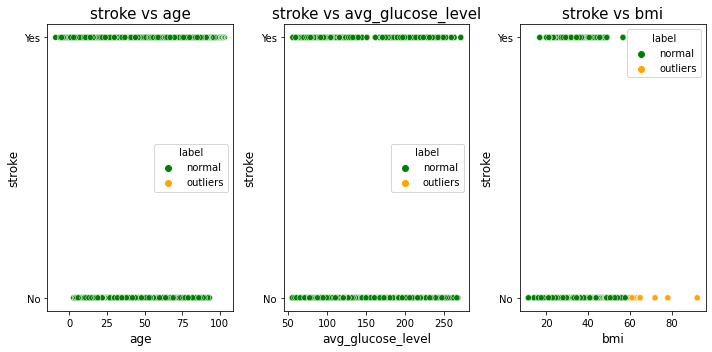

In [12]:
df['label'] = 'normal'
df.loc[outliers_indexes, 'label'] = 'outliers'

target = 'stroke'
columns_outliers  = df.select_dtypes(include='float64').columns
colors_outliers = ['green', 'orange']

f, ax = plt.subplots(1, 3, figsize=(10,5), tight_layout = True)
CustomPalette = sns.set_palette(sns.color_palette(colors_outliers))

for i, col in enumerate(columns_outliers):
    sns.scatterplot(data=df, x=col, y=target, hue='label', ax=ax[i])
    ax[i].set_title(f'{target} vs {col}', size=15)
    ax[i].set_xlabel(col, size=12)
    ax[i].set_ylabel(target, size=12)    

In [13]:
df.drop('label', axis=1, inplace=True)

### Discover Duplicates

In [14]:
df[df.duplicated(keep=False)]

,sex,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke


### Discover Missing Values

In [15]:
df.isnull().sum()

sex                  3
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

**Imputing Missing Values**

In [16]:
df['sex'].fillna(df['sex'].mode()[0], inplace=True)

In [17]:
df.isnull().sum()

sex                  0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

## EDA

### Categorical Variables Analysis

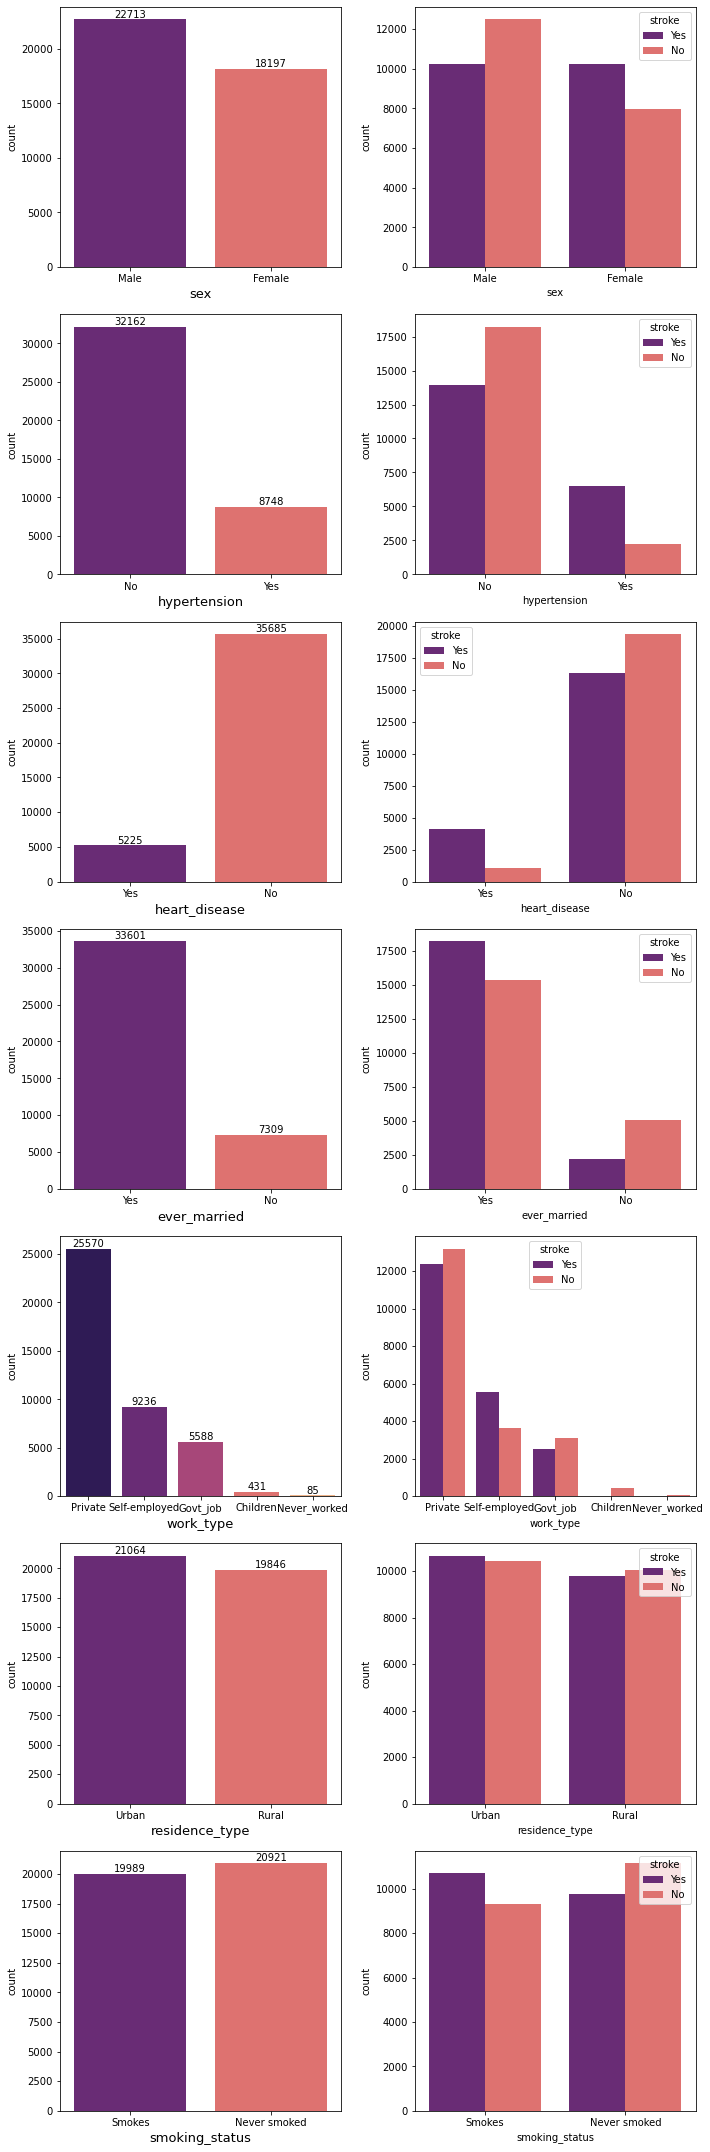

In [18]:
columns = df.select_dtypes(include='object').columns
columns = columns[:-1]

fig, ax = plt.subplots(7, 2, figsize=(10,30), tight_layout=True)

for i, col in enumerate(columns):
    graph = sns.countplot(x=col, data=df, palette='magma', ax=ax[i,0])
    for cont in graph.containers:
        graph.bar_label(cont)
    ax[i,0].set_xlabel(col, size=13)

    sns.countplot(x=col, hue=target, data=df, palette='magma', ax=ax[i,1])

### Numerical Variables Analysis

Text(0.5, 0.98, 'Distribution of Numerical Variables')

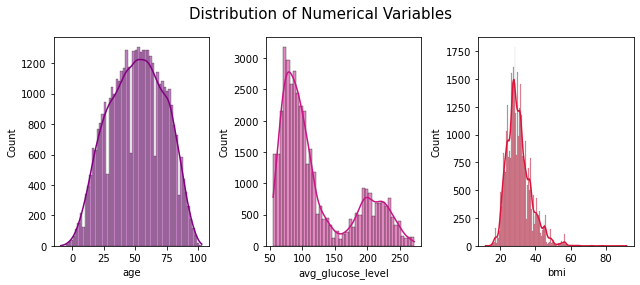

In [19]:
f, ax = plt.subplots(1, 3, figsize=(9,4), tight_layout=True)

columns = df.select_dtypes(include='float64').columns
for i, col in enumerate(columns):
    sns.histplot(df[col], kde=True, ax=ax[i], color=colors[i])
    ax[i].set_xlabel(col, fontsize=10)

plt.suptitle('Distribution of Numerical Variables', fontsize=15)

**The distribution of the *age* column resembles the normal one. The distributions of the *bmi* and *avg_glucose_level* columns are right skewed.**

## Categorical Variables Encoding

In [20]:
df = pd.get_dummies(df, columns=['work_type'], 
                    prefix=col,
                    drop_first=True)

col=['sex', 'hypertension', 'heart_disease', 'ever_married', 
     'residence_type', 'smoking_status', 'stroke']
df[col] = df[col].apply(LabelEncoder().fit_transform)

df.head(5)

,sex,age,hypertension,heart_disease,ever_married,residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_Govt_job,bmi_Never_worked,bmi_Private,bmi_Self-employed
0,1,63.0,0,1,1,1,228.69,36.6,1,1,0,0,1,0
1,1,42.0,0,1,1,0,105.92,32.5,0,1,0,0,1,0
2,0,61.0,0,0,1,1,171.23,34.4,1,1,0,0,1,0
3,1,41.0,1,0,1,0,174.12,24.0,0,1,0,0,0,1
4,1,85.0,0,0,1,1,186.21,29.0,1,1,0,0,1,0


## Correlation Analysis

<AxesSubplot:>

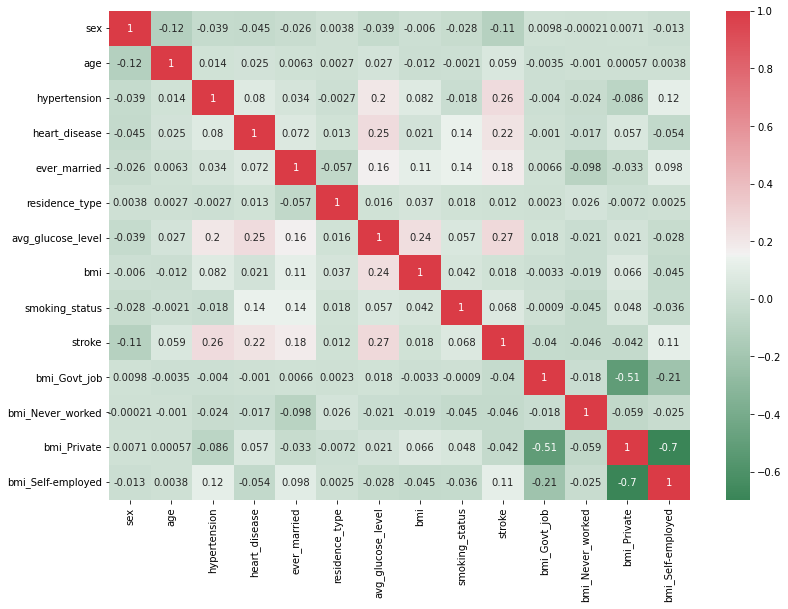

In [21]:
plt.figure(figsize=(13,9))
cmap = sns.diverging_palette(500, 10, as_cmap=True)
sns.heatmap(df.corr(), annot=True, cmap=cmap)

## Split the Dataset

In [22]:
X = df.drop(target, axis=1)
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)

## Evaluation using Cross Validation

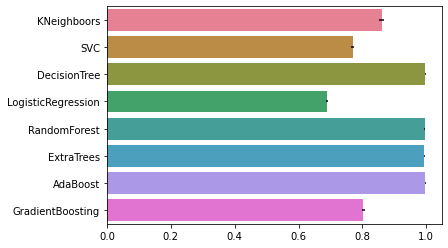

In [23]:
random_state = 2
Kfold = StratifiedKFold(n_splits=6)

pipelines = [make_pipeline(StandardScaler(), KNeighborsClassifier()), 
             make_pipeline(StandardScaler(), SVC(random_state=random_state)),
             make_pipeline(DecisionTreeClassifier(random_state=random_state)),
             make_pipeline(StandardScaler(), LogisticRegression(random_state = random_state)),
             make_pipeline(RandomForestClassifier(random_state=random_state)),
             make_pipeline(ExtraTreesClassifier(random_state=random_state)),
             make_pipeline(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state), 
                                              random_state=random_state, learning_rate=0.1)),
             make_pipeline(GradientBoostingClassifier(random_state=random_state))]

cv_results = []
cv_mean = []
cv_std = []

for pipeline in pipelines:
    cv_results.append(cross_val_score(pipeline, X_train, y_train,
                                      scoring='accuracy', cv=Kfold, n_jobs=4))
    
for result in cv_results:
    cv_mean.append(result.mean())
    cv_std.append(result.std())
    
model_names = ['KNeighboors', 'SVC', 'DecisionTree', 
               'LogisticRegression', 'RandomForest', 
               'ExtraTrees', 'AdaBoost', 'GradientBoosting']    
cv_plot = sns.barplot(x=cv_mean, y=model_names, palette='husl', orient='h', **{'xerr':cv_std})

In [23]:
pd.DataFrame({'Accuracy': cv_mean}, index=model_names)

,Accuracy
KNeighboors,0.860879
SVC,0.769354
DecisionTree,0.997660
LogisticRegression,0.688131
RandomForest,0.995635
ExtraTrees,0.993260
AdaBoost,0.997625
GradientBoosting,0.803227


The models that were selected for further investigation are: DecisionTree, RandomForest, AdaBoost.

## Hyperparameter Tuning

### Hyperparameter tuning on DecisionTree

In [29]:
dtree = DecisionTreeClassifier()

parameters = {
    'max_depth': [16, 32, None],
    'min_samples_leaf': [5, 10, 20, 50],
    'min_samples_split': [2, 5, 10, 20],
    'max_features': [0.3, 0.1, 'sqrt', None]}


gs_dtree = GridSearchCV(dtree, param_grid=parameters, cv=Kfold,
                      scoring='accuracy', n_jobs=-1, verbose=2)

gs_dtree.fit(X_train, y_train)

Fitting 6 folds for each of 192 candidates, totalling 1152 fits


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [16, 32, None],
                         'max_features': [0.3, 0.1, 'sqrt', None],
                         'min_samples_leaf': [5, 10, 20, 50],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='accuracy', verbose=2)

In [30]:
dtree_best = gs_dtree.best_estimator_
dtree_best_score = gs_dtree.best_score_

print('Best parameters for Decision Tree Classifier:', dtree_best)
print('Best score:', dtree_best_score)

Best parameters for Decision Tree Classifier: DecisionTreeClassifier(max_depth=32, min_samples_leaf=5, min_samples_split=20)
Best score: 0.992597058158765


### Hyperparameter tuning on Random Forest Classifier

In [19]:
rf = RandomForestClassifier()

parameters = {'n_estimators': [50, 100, 200],
              'max_depth': [16, 32],
              'min_samples_split': [5, 10, 20],
              'min_samples_leaf': [5, 10, 20],
              'max_features': [0.3, 0.1]}

gs_rf = GridSearchCV(rf, param_grid=parameters, cv=Kfold,
                      scoring='accuracy', n_jobs=-1, verbose=1)

gs_rf.fit(X_train, y_train)

Fitting 6 folds for each of 108 candidates, totalling 648 fits


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [16, 32], 'max_features': [0.3, 0.1],
                         'min_samples_leaf': [5, 10, 20],
                         'min_samples_split': [5, 10, 20],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [20]:
rf_best = gs_rf.best_estimator_
rf_best_score = gs_rf.best_score_

print('Best parameters for Random Forest Classifier:', rf_best)
print('Best score:', rf_best_score)

Best parameters for Random Forest Classifier: RandomForestClassifier(max_depth=32, max_features=0.3, min_samples_leaf=5,
                       min_samples_split=10)
Best score: 0.9846701391541447


### Hyperparameter tuning on AdaBoost Classifier

In [31]:
ab = AdaBoostClassifier(dtree_best)

parameters = {'learning_rate': [1, 0.5, 0.1, 0.01],
              'n_estimators': [50, 100, 200],
              'algorithm': ['SAMME', 'SAMME.R']}

gs_ab = GridSearchCV(ab, param_grid=parameters, cv=Kfold,
                      scoring='accuracy', n_jobs=-1, verbose=1)

gs_ab.fit(X_train, y_train)

Fitting 6 folds for each of 24 candidates, totalling 144 fits


GridSearchCV(cv=StratifiedKFold(n_splits=6, random_state=None, shuffle=False),
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=32,
                                                                                min_samples_leaf=5,
                                                                                min_samples_split=20)),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [1, 0.5, 0.1, 0.01],
                         'n_estimators': [50, 100, 200]},
             scoring='accuracy', verbose=1)

In [32]:
ab_best = gs_ab.best_estimator_
ab_best_score = gs_ab.best_score_

print('Best parameters for AdaBoost Classifier:', ab_best)
print('Best score:', ab_best_score)

Best parameters for AdaBoost Classifier: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=32,
                                                         min_samples_leaf=5,
                                                         min_samples_split=20),
                   learning_rate=0.01, n_estimators=200)
Best score: 0.9998603254417208


### Results

In [92]:
models = ['DecisisonTree', 'RandomForest', 'AdaBoost']
scores = [dtree_best_score, rf_best_score, ab_best_score]

pd.DataFrame({'Model': models,
              'Accuracy': scores})

,Model,Accuracy
0,DecisisonTree,0.992597
1,RandomForest,0.984670
2,AdaBoost,0.999860


Among the models tested, AdaBoost and DecisionTree have the highest accuracy, but overall the accuracy of all models is about the same.

### Check models for overfitting

In [93]:
dt = dtree_best
rf = rf_best
ab = ab_best

test_accuracy = []
train_accuracy = []

for model in [dt, rf, ab]:
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    train_accuracy.append(accuracy_score(y_train, y_pred_train))
    test_accuracy.append(accuracy_score(y_test, y_pred_test))


pd.DataFrame(data={ 'Train acc.': train_accuracy, 'Test acc.': test_accuracy},
             index=['DecisionTree', 'RandonForest', 'AdaBoost'])

,Train acc.,Test acc.
DecisionTree,0.997346,0.994867
RandonForest,0.995146,0.989245
AdaBoost,1.000000,0.999348


The accuracy measured on the training and test data sets is almost the same, so models do not overfit.

## Final Model Investigation

### Confusion matrix

In [98]:
y_pred = ab.predict(X_test)

In [99]:
cm = confusion_matrix(y_test, y_pred)

pd.DataFrame(data=cm, columns=['Actual Positive', 'Actual Negative'],
             index=['Predicted Positive', 'Predicted Negative'])

,Actual Positive,Actual Negative
Predicted Positive,6112,8
Predicted Negative,0,6153


<AxesSubplot:>

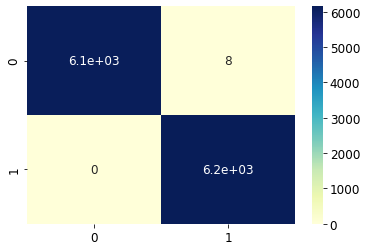

In [100]:
sns.heatmap(cm, annot=True, cmap='YlGnBu')

### Classification metrices

In [102]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall =  recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

pd.DataFrame(data=[accuracy, precision, recall, f1],
             columns=['Score'],
             index=['Test accuracy', 'Precision', 'Recall', 'F1'])

,Score
Test accuracy,0.999348
Precision,0.998702
Recall,1.000000
F1,0.999350


### ROC Curve

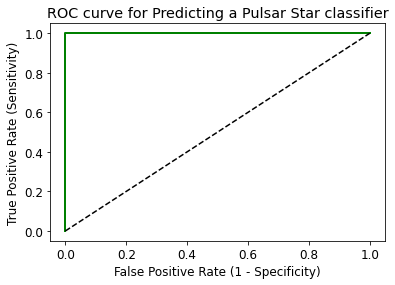

In [103]:
fpr, tpr, thresholds = roc_curve(y_train, y_pred_train)

plt.figure(figsize=(6,4))

plt.plot(fpr, tpr, linewidth=2)
plt.plot([0,1], [0,1], 'k--' )

plt.rcParams['font.size'] = 12
plt.title('ROC curve for Predicting a Pulsar Star classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')

plt.show()

In [104]:
roc_auc = roc_auc_score(y_test, y_pred)
print('ROC AUC score:', round(roc_auc, 5))

ROC AUC score: 0.99935


## Conclusion

In [105]:
df['stroke'].value_counts()

1    20460
0    20450
Name: stroke, dtype: int64

- The AdaBoosting classifier shows the best performance among all other classifiers (accuracy=99.9%). And since the used dataset isn't imbalanced (had stroke: 20460, didn't have stroke: 20450), we can use accuracy for estimating classifier performance.
- Analysis of other metrics was also carried out. In particular, the ROC_AUC score of our model is very close to 1 (0.999), so our model classifies diagnoses very well.
- Using GridSearch improved the performance of the model (0.997→0.999).